# Dice Detection Training

## 1. Setup & Installation

In [ ]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install system dependencies for pillow-avif-plugin
!sudo apt-get update
!sudo apt-get install -y libheif-dev libavif-dev

!pip install roboflow matplotlib seaborn tqdm numpy pillow

Looking in indexes: https://download.pytorch.org/whl/cu118
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,359 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinoi

In [ ]:
# Clone the git repository with the code
import os
if not os.path.exists('Dice-Detection'):
    !git clone https://github.com/Adr44mo/Dice-Detection.git
    %cd Dice-Detection
else:
    %cd Dice-Detection

# Add src to path
import sys
sys.path.append('./src')

/content/Dice-Detection


## 2. Import Libraries

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os

# Import custom modules
from src.dataset import DiceDetectionDataset, collate_fn
from src.model import get_fasterrcnn_model, save_model_checkpoint
from src.training import train_one_epoch, evaluate, get_optimizer, get_lr_scheduler
from src.metrics import evaluate_map, print_metrics
from src.augmentation import ClassAwareSampler, MosaicAugmentation, apply_random_augmentations
from src.visualization import (
    plot_class_distribution,
    plot_training_history,
    display_sample_batch,
    visualize_predictions,
    plot_ap_comparison
)
from src.aug.annotation_manager import AnnotationManager
from src.aug.difficulty_sampling import DifficultyAwareSampler
from src.aug.copy_paste import CopyPasteAugmentation
from src.Loss_function import RoIHeadsWithFocalLoss, FocalLoss

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: Tesla T4


## 3. Configuration

In [ ]:
# =============================================================================
# AUGMENTATION CONFIGURATION
# =============================================================================

# Sampling
USE_CLASS_AWARE_SAMPLING = True
USE_DIFFICULTY_AWARE_SAMPLING = True
DIFFICULTY_WEIGHT = 0.5

# Augmentation
USE_MOSAIC_AUGMENTATION = True
MOSAIC_PROB = 0.5
USE_RANDOM_AUGMENTATION = True
USE_COPY_PASTE = False
COPY_PASTE_PROB = 0.5

# =============================================================================
# CUSTOM LOSS FUNCTION CONFIGURATION
# =============================================================================

# Enable Focal Loss for class imbalance handling
USE_FOCAL_LOSS = False

# Focal Loss hyperparameters
# alpha: Weighting factor for the rare class
# gamma: Focusing parameter
FOCAL_LOSS_ALPHA = 0.25
FOCAL_LOSS_GAMMA = 2.0

# =============================================================================
# ANNOTATION FILES
# =============================================================================

TRAIN_ANNOTATION = 'train_balanced.coco.json'
VAL_ANNOTATION = 'val_balanced.coco.json'

TEST_ANNOTATION = 'test_balanced.coco.json'

# =============================================================================
# PRINT CONFIGURATION SUMMARY
# =============================================================================
print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print("\n[Augmentation Settings]")
print(f"  Class-Aware Sampling: {'ON' if USE_CLASS_AWARE_SAMPLING else 'OFF'}")
print(f"  Difficulty-Aware Sampling: {'ON' if USE_DIFFICULTY_AWARE_SAMPLING else 'OFF'}")
print(f"  Mosaic Augmentation: {'ON' if USE_MOSAIC_AUGMENTATION else 'OFF'} (prob={MOSAIC_PROB})")
print(f"  Random Augmentation: {'ON' if USE_RANDOM_AUGMENTATION else 'OFF'}")
print(f"  Copy-Paste: {'ON' if USE_COPY_PASTE else 'OFF'}")

print("\n[Loss Function Settings]")
print(f"  Focal Loss: {'ON' if USE_FOCAL_LOSS else 'OFF (Standard Cross-Entropy)'}")
if USE_FOCAL_LOSS:
    print(f"    Alpha: {FOCAL_LOSS_ALPHA}")
    print(f"    Gamma: {FOCAL_LOSS_GAMMA}")
print("="*60)

TRAINING CONFIGURATION

[Augmentation Settings]
  Class-Aware Sampling: ON
  Difficulty-Aware Sampling: ON
  Mosaic Augmentation: ON (prob=0.5)
  Random Augmentation: ON
  Copy-Paste: OFF
  GAN Dataset: OFF

[Loss Function Settings]
  Focal Loss: OFF (Standard Cross-Entropy)


## 4. Download Dataset from Roboflow

In [ ]:
from roboflow import Roboflow

# TODO: Add your Roboflow API key
rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")

# Download the dice dataset
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/Dice-Detection/dice-2


## 5. Prepare Datasets

### 5.5. Load Custom Annotations

Load annotations from the `Annotations` folder and copy them to the dataset directories.

In [ ]:
# Initialize Annotation Manager
anno_manager = AnnotationManager('./Annotations')

print(f'Loading annotations:')
print(f'  Train: {TRAIN_ANNOTATION}')
print(f'  Val: {VAL_ANNOTATION}')
print(f'  Test: {TEST_ANNOTATION}')

# Load selected annotations
train_anno = anno_manager.load_annotation_set(TRAIN_ANNOTATION)
val_anno = anno_manager.load_annotation_set(VAL_ANNOTATION)
test_anno = anno_manager.load_annotation_set(TEST_ANNOTATION)

# Get stats
train_stats = anno_manager.get_dataset_stats(TRAIN_ANNOTATION)
val_stats = anno_manager.get_dataset_stats(VAL_ANNOTATION)
test_stats = anno_manager.get_dataset_stats(TEST_ANNOTATION)

print(f'\nTrain: {train_stats["num_images"]} images, {train_stats["num_annotations"]} annotations')
print(f'Val: {val_stats["num_images"]} images, {val_stats["num_annotations"]} annotations')
print(f'Test: {test_stats["num_images"]} images, {test_stats["num_annotations"]} annotations')

# Set paths (will be defined in next cell)
DATASET_PATH = dataset.location
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "valid")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Write annotations to dataset paths (override Roboflow annotations)
import shutil
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

with open(os.path.join(TRAIN_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(train_anno, f)

with open(os.path.join(VAL_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(val_anno, f)

with open(os.path.join(TEST_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(test_anno, f)

print('\n✓ Annotations loaded and copied to dataset directories!')
print(f'  Train: {TRAIN_PATH}/_annotations.coco.json')
print(f'  Val: {VAL_PATH}/_annotations.coco.json')
print(f'  Test: {TEST_PATH}/_annotations.coco.json')

Loading annotations:
  Train: train_balanced.coco.json
  Val: val_balanced.coco.json
  Test: test_balanced.coco.json

Train: 1227 images, 2562 annotations
Val: 128 images, 354 annotations
Test: 104 images, 150 annotations

✓ Annotations loaded and copied to dataset directories!
  Train: /content/Dice-Detection/dice-2/train/_annotations.coco.json
  Val: /content/Dice-Detection/dice-2/valid/_annotations.coco.json
  Test: /content/Dice-Detection/dice-2/test/_annotations.coco.json


In [ ]:
# Set dataset paths

# Check if test set exists
has_test_set = os.path.exists(TEST_PATH) and os.path.exists(os.path.join(TEST_PATH, "_annotations.coco.json"))
print(f"Test set available: {has_test_set}")

# Create datasets
train_dataset = DiceDetectionDataset(
    root_dir=TRAIN_PATH,
    annotation_file="_annotations.coco.json",
    split="train"
)

val_dataset = DiceDetectionDataset(
    root_dir=VAL_PATH,
    annotation_file="_annotations.coco.json",
    split="val"
)

# Create test dataset if available
if has_test_set:
    test_dataset = DiceDetectionDataset(
        root_dir=TEST_PATH,
        annotation_file="_annotations.coco.json",
        split="test"
    )
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
else:
    test_dataset = None
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"No test set - will use validation set for final evaluation")

print(f"Number of classes: {train_dataset.num_classes}")

Test set available: True
Training dataset size: 1227
Validation dataset size: 128
Test dataset size: 104
Number of classes: 8


## 6. Flexible Augmentation Wrapper

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    """Wrapper dataset that applies configured augmentations"""

    def __init__(self, base_dataset, use_mosaic=True, mosaic_prob=0.5, use_random=True, use_copy_paste=False, copy_paste_prob=0.5):
        self.base_dataset = base_dataset
        self.use_mosaic = use_mosaic
        self.use_random = use_random
        self.use_copy_paste = use_copy_paste

        if use_mosaic:
            self.mosaic = MosaicAugmentation(
                base_dataset,
                output_size=(640, 640),
                prob=mosaic_prob
            )
            if use_copy_paste:
                self.copy_paste = CopyPasteAugmentation(
                    base_dataset, prob=copy_paste_prob, num_instances=(1, 3))

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Apply Mosaic if enabled
        if self.use_mosaic:
            image, target = self.mosaic(idx)
        else:
            image, target = self.base_dataset[idx]

        if self.use_copy_paste:
            self.base_dataset._temp_override = (image, target)
            image, target = self.copy_paste(idx)
            if hasattr(self.base_dataset, '_temp_override'):
                delattr(self.base_dataset, '_temp_override')

        # Convert tensor to PIL if needed for augmentations
        if isinstance(image, torch.Tensor):
            from torchvision.transforms import functional as F
            image = F.to_pil_image(image)

        # Apply Random Augmentations if enabled
        if self.use_random:
            image, target = apply_random_augmentations(image, target)

        # Convert back to tensor
        from torchvision.transforms import ToTensor
        image = ToTensor()(image)

        return image, target

# Create augmented training dataset based on config
augmented_train_dataset = AugmentedDataset(
    train_dataset,
    use_mosaic=USE_MOSAIC_AUGMENTATION,
    mosaic_prob=MOSAIC_PROB,
    use_random=USE_RANDOM_AUGMENTATION,
    use_copy_paste=USE_COPY_PASTE,
    copy_paste_prob=COPY_PASTE_PROB
)

print(f"Created dataset wrapper with:")
print(f"  Mosaic: {USE_MOSAIC_AUGMENTATION}")
print(f"  Random Augmentations: {USE_RANDOM_AUGMENTATION}")

Created dataset wrapper with:
  Mosaic: True
  Random Augmentations: True


## 7. Create Data Loaders with Optional Sampling

In [ ]:
# Hyperparameters
BATCH_SIZE = 8
NUM_WORKERS = 4
NUM_EPOCHS = 5
LEARNING_RATE = 0.005
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Configure Sampler
if USE_DIFFICULTY_AWARE_SAMPLING and USE_CLASS_AWARE_SAMPLING:
    print('Both samplers on, using Difficulty-Aware')
    USE_CLASS_AWARE_SAMPLING = False

if USE_DIFFICULTY_AWARE_SAMPLING:
    train_sampler = DifficultyAwareSampler(
        train_dataset, samples_per_epoch=len(train_dataset) * 2,
        difficulty_weight=DIFFICULTY_WEIGHT)
    shuffle = False
    print('Difficulty-Aware sampler created')
elif USE_CLASS_AWARE_SAMPLING:
    train_sampler = ClassAwareSampler(
        train_dataset, samples_per_epoch=len(train_dataset) * 2)
    shuffle = False
    print('Class-Aware sampler created')
else:
    train_sampler = None
    shuffle = True
    print('No sampler created')

# Create data loaders
train_loader = data.DataLoader(
    augmented_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=shuffle,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Both samplers on, using Difficulty-Aware
Calculating difficulty scores for all instances...
Difficulty-aware sampler initialized:
  Classes: 6
  Images with annotations: 1184
  Average difficulty by class:
    Class 1: 0.691
    Class 2: 0.730
    Class 3: 0.709
    Class 4: 0.728
    Class 5: 0.709
    Class 6: 0.703
Difficulty-Aware sampler created
Training batches: 154
Validation batches: 8


## 8. Initialize Model with Custom Loss Function

In [ ]:
# Create model with optional Focal Loss
print(f"Creating model with Focal Loss: {USE_FOCAL_LOSS}")

"""model = get_fasterrcnn_mobilenet(
    num_classes=train_dataset.num_classes,
    pretrained=True,
    trainable_backbone_layers=3,
    use_focal_loss=USE_FOCAL_LOSS,
    alpha=FOCAL_LOSS_ALPHA,
    gamma=FOCAL_LOSS_GAMMA
)"""
model = get_fasterrcnn_model(
    num_classes=train_dataset.num_classes,
    pretrained=True,
    trainable_backbone_layers=3,
    use_focal_loss=USE_FOCAL_LOSS,
    alpha=FOCAL_LOSS_ALPHA,
    gamma=FOCAL_LOSS_GAMMA
)

model.to(DEVICE)

# Setup optimizer and scheduler
optimizer = get_optimizer(model, lr=LEARNING_RATE)
lr_scheduler = get_lr_scheduler(optimizer, step_size=3, gamma=0.1)

print(f"Model initialized on {DEVICE}")
if USE_FOCAL_LOSS:
    print(f"  Using Focal Loss (alpha={FOCAL_LOSS_ALPHA}, gamma={FOCAL_LOSS_GAMMA})")
    print(f"  RoI Heads type: {type(model.roi_heads).__name__}")
else:
    print(f"  Using Standard Cross-Entropy Loss")

Creating model with Focal Loss: False
Model initialized on cuda
  Using Standard Cross-Entropy Loss


### Verify Custom Loss Function Setup

In [ ]:
# Verify the loss function is properly configured
if USE_FOCAL_LOSS:
    print("Verifying Focal Loss configuration...")
    print(f"  Model RoI Heads: {type(model.roi_heads).__name__}")

    if hasattr(model.roi_heads, 'focal_loss'):
        fl = model.roi_heads.focal_loss
        print(f"    Focal Loss attached to RoI Heads")
        print(f"    Alpha: {fl.alpha}")
        print(f"    Gamma: {fl.gamma}")
        print(f"    Reduction: {fl.reduction}")
    else:
        print("  Warning: Focal Loss not found in RoI Heads")
else:
    print("Standard Cross-Entropy Loss is being used.")

Standard Cross-Entropy Loss is being used.


## 9. Training Loop

In [ ]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

best_val_loss = float('inf')

# Include focal loss in checkpoint directory name
loss_str = f"fl{int(USE_FOCAL_LOSS)}" if USE_FOCAL_LOSS else "ce"
CHECKPOINT_DIR = f"checkpoints_comparison_{loss_str}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Starting training...")
print(f"Checkpoint directory: {CHECKPOINT_DIR}\n")

Starting training...
Checkpoint directory: checkpoints_comparison_ce



In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_metrics = train_one_epoch(
        model, optimizer, train_loader, DEVICE, epoch + 1
    )

    # Evaluate
    val_metrics = evaluate(model, val_loader, DEVICE)

    # Update learning rate
    lr_scheduler.step()

    # Record history
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['val_loss'])
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    # Print summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_metrics['loss']:.4f}")
    print(f"  Val Loss: {val_metrics['val_loss']:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"  Time: {train_metrics['time']:.2f}s")

    # Generate config string for filenames (include focal loss info)
    config_str = f"ca{int(USE_CLASS_AWARE_SAMPLING)}_mo{int(USE_MOSAIC_AUGMENTATION)}_rn{int(USE_RANDOM_AUGMENTATION)}_fl{int(USE_FOCAL_LOSS)}"

    # Save best model
    if val_metrics['val_loss'] < best_val_loss:
        best_val_loss = val_metrics['val_loss']
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_{config_str}.pth")
        save_model_checkpoint(
            model, optimizer, epoch + 1, val_metrics['val_loss'],
            checkpoint_path,
            additional_info={
                'train_loss': train_metrics['loss'],
                'config': config_str,
                'use_focal_loss': USE_FOCAL_LOSS,
                'focal_alpha': FOCAL_LOSS_ALPHA if USE_FOCAL_LOSS else None,
                'focal_gamma': FOCAL_LOSS_GAMMA if USE_FOCAL_LOSS else None
            }
        )
        print(f"  ✓ New best model saved!")

    # Save latest checkpoint
    latest_path = os.path.join(CHECKPOINT_DIR, f"latest_model_{config_str}.pth")
    save_model_checkpoint(
        model, optimizer, epoch + 1, val_metrics['val_loss'],
        latest_path
    )

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Epoch 1/5


Epoch 1:   6%|▋         | 10/154 [00:44<08:44,  3.64s/it]

  Batch [10/154] Loss: 1.4028 (Cls: 0.7688, Box: 0.5674, Obj: 0.0353, RPN: 0.0313)


Epoch 1:  13%|█▎        | 20/154 [01:16<06:59,  3.13s/it]

  Batch [20/154] Loss: 1.1778 (Cls: 0.5912, Box: 0.5284, Obj: 0.0242, RPN: 0.0339)


Epoch 1:  19%|█▉        | 30/154 [01:48<06:42,  3.25s/it]

  Batch [30/154] Loss: 1.0594 (Cls: 0.5296, Box: 0.4792, Obj: 0.0191, RPN: 0.0314)


Epoch 1:  26%|██▌       | 40/154 [02:21<06:14,  3.28s/it]

  Batch [40/154] Loss: 0.9663 (Cls: 0.4934, Box: 0.4272, Obj: 0.0165, RPN: 0.0291)


Epoch 1:  32%|███▏      | 50/154 [02:53<05:36,  3.24s/it]

  Batch [50/154] Loss: 0.8903 (Cls: 0.4656, Box: 0.3828, Obj: 0.0147, RPN: 0.0272)


Epoch 1:  39%|███▉      | 60/154 [03:26<05:09,  3.29s/it]

  Batch [60/154] Loss: 0.8322 (Cls: 0.4450, Box: 0.3485, Obj: 0.0130, RPN: 0.0256)


Epoch 1:  45%|████▌     | 70/154 [03:59<04:34,  3.27s/it]

  Batch [70/154] Loss: 0.7928 (Cls: 0.4326, Box: 0.3235, Obj: 0.0118, RPN: 0.0249)


Epoch 1:  52%|█████▏    | 80/154 [04:31<04:03,  3.29s/it]

  Batch [80/154] Loss: 0.7559 (Cls: 0.4194, Box: 0.3013, Obj: 0.0110, RPN: 0.0242)


Epoch 1:  58%|█████▊    | 90/154 [05:04<03:29,  3.27s/it]

  Batch [90/154] Loss: 0.7273 (Cls: 0.4083, Box: 0.2843, Obj: 0.0106, RPN: 0.0241)


Epoch 1:  65%|██████▍   | 100/154 [05:37<02:56,  3.28s/it]

  Batch [100/154] Loss: 0.6940 (Cls: 0.3921, Box: 0.2682, Obj: 0.0100, RPN: 0.0238)


Epoch 1:  71%|███████▏  | 110/154 [06:10<02:24,  3.28s/it]

  Batch [110/154] Loss: 0.6652 (Cls: 0.3779, Box: 0.2552, Obj: 0.0094, RPN: 0.0227)


Epoch 1:  78%|███████▊  | 120/154 [06:42<01:50,  3.26s/it]

  Batch [120/154] Loss: 0.6412 (Cls: 0.3651, Box: 0.2449, Obj: 0.0089, RPN: 0.0222)


Epoch 1:  84%|████████▍ | 130/154 [07:15<01:18,  3.28s/it]

  Batch [130/154] Loss: 0.6167 (Cls: 0.3519, Box: 0.2343, Obj: 0.0086, RPN: 0.0220)


Epoch 1:  91%|█████████ | 140/154 [07:48<00:45,  3.26s/it]

  Batch [140/154] Loss: 0.5964 (Cls: 0.3405, Box: 0.2261, Obj: 0.0082, RPN: 0.0216)


Epoch 1:  97%|█████████▋| 150/154 [08:20<00:12,  3.23s/it]

  Batch [150/154] Loss: 0.5779 (Cls: 0.3296, Box: 0.2192, Obj: 0.0080, RPN: 0.0212)


Evaluating: 100%|██████████| 8/8 [00:12<00:00,  1.62s/it]



Epoch 1 Summary:
  Train Loss: 0.5703
  Val Loss: 0.1315
  Learning Rate: 0.005000
  Time: 511.69s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn1_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn1_fl0.pth

Epoch 2/5


Epoch 2:   6%|▋         | 10/154 [00:44<08:58,  3.74s/it]

  Batch [10/154] Loss: 0.3044 (Cls: 0.1605, Box: 0.1252, Obj: 0.0037, RPN: 0.0150)


Epoch 2:  13%|█▎        | 20/154 [01:17<07:12,  3.22s/it]

  Batch [20/154] Loss: 0.2954 (Cls: 0.1539, Box: 0.1200, Obj: 0.0034, RPN: 0.0182)


Epoch 2:  19%|█▉        | 30/154 [01:48<06:36,  3.20s/it]

  Batch [30/154] Loss: 0.2831 (Cls: 0.1462, Box: 0.1178, Obj: 0.0033, RPN: 0.0158)


Epoch 2:  26%|██▌       | 40/154 [02:21<06:15,  3.30s/it]

  Batch [40/154] Loss: 0.2742 (Cls: 0.1388, Box: 0.1158, Obj: 0.0033, RPN: 0.0163)


Epoch 2:  32%|███▏      | 50/154 [02:54<05:35,  3.23s/it]

  Batch [50/154] Loss: 0.2656 (Cls: 0.1330, Box: 0.1132, Obj: 0.0033, RPN: 0.0162)


Epoch 2:  39%|███▉      | 60/154 [03:26<05:03,  3.23s/it]

  Batch [60/154] Loss: 0.2627 (Cls: 0.1298, Box: 0.1135, Obj: 0.0032, RPN: 0.0161)


Epoch 2:  45%|████▌     | 70/154 [03:59<04:34,  3.27s/it]

  Batch [70/154] Loss: 0.2610 (Cls: 0.1271, Box: 0.1143, Obj: 0.0031, RPN: 0.0165)


Epoch 2:  52%|█████▏    | 80/154 [04:31<03:59,  3.24s/it]

  Batch [80/154] Loss: 0.2572 (Cls: 0.1251, Box: 0.1133, Obj: 0.0030, RPN: 0.0158)


Epoch 2:  58%|█████▊    | 90/154 [05:04<03:29,  3.27s/it]

  Batch [90/154] Loss: 0.2548 (Cls: 0.1239, Box: 0.1118, Obj: 0.0030, RPN: 0.0160)


Epoch 2:  65%|██████▍   | 100/154 [05:36<02:55,  3.26s/it]

  Batch [100/154] Loss: 0.2519 (Cls: 0.1223, Box: 0.1107, Obj: 0.0029, RPN: 0.0159)


Epoch 2:  71%|███████▏  | 110/154 [06:09<02:23,  3.26s/it]

  Batch [110/154] Loss: 0.2488 (Cls: 0.1204, Box: 0.1095, Obj: 0.0031, RPN: 0.0158)


Epoch 2:  78%|███████▊  | 120/154 [06:42<01:50,  3.26s/it]

  Batch [120/154] Loss: 0.2441 (Cls: 0.1179, Box: 0.1080, Obj: 0.0031, RPN: 0.0152)


Epoch 2:  84%|████████▍ | 130/154 [07:14<01:18,  3.26s/it]

  Batch [130/154] Loss: 0.2410 (Cls: 0.1161, Box: 0.1070, Obj: 0.0030, RPN: 0.0149)


Epoch 2:  91%|█████████ | 140/154 [07:47<00:45,  3.26s/it]

  Batch [140/154] Loss: 0.2385 (Cls: 0.1148, Box: 0.1059, Obj: 0.0031, RPN: 0.0148)


Epoch 2:  97%|█████████▋| 150/154 [08:19<00:12,  3.23s/it]

  Batch [150/154] Loss: 0.2359 (Cls: 0.1134, Box: 0.1048, Obj: 0.0031, RPN: 0.0146)


Evaluating: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]



Epoch 2 Summary:
  Train Loss: 0.2347
  Val Loss: 0.0742
  Learning Rate: 0.005000
  Time: 511.11s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn1_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn1_fl0.pth

Epoch 3/5


Epoch 3:   6%|▋         | 10/154 [00:43<08:41,  3.62s/it]

  Batch [10/154] Loss: 0.2083 (Cls: 0.0916, Box: 0.0980, Obj: 0.0029, RPN: 0.0158)


Epoch 3:  13%|█▎        | 20/154 [01:16<07:13,  3.24s/it]

  Batch [20/154] Loss: 0.2005 (Cls: 0.0899, Box: 0.0945, Obj: 0.0027, RPN: 0.0134)


Epoch 3:  19%|█▉        | 30/154 [01:48<06:39,  3.22s/it]

  Batch [30/154] Loss: 0.1986 (Cls: 0.0890, Box: 0.0926, Obj: 0.0026, RPN: 0.0144)


Epoch 3:  26%|██▌       | 40/154 [02:21<06:15,  3.29s/it]

  Batch [40/154] Loss: 0.1958 (Cls: 0.0878, Box: 0.0915, Obj: 0.0026, RPN: 0.0139)


Epoch 3:  32%|███▏      | 50/154 [02:53<05:35,  3.22s/it]

  Batch [50/154] Loss: 0.1938 (Cls: 0.0869, Box: 0.0901, Obj: 0.0027, RPN: 0.0141)


Epoch 3:  39%|███▉      | 60/154 [03:26<05:05,  3.25s/it]

  Batch [60/154] Loss: 0.1932 (Cls: 0.0868, Box: 0.0894, Obj: 0.0026, RPN: 0.0144)


Epoch 3:  45%|████▌     | 70/154 [03:58<04:34,  3.27s/it]

  Batch [70/154] Loss: 0.1933 (Cls: 0.0872, Box: 0.0891, Obj: 0.0025, RPN: 0.0145)


Epoch 3:  52%|█████▏    | 80/154 [04:31<04:02,  3.27s/it]

  Batch [80/154] Loss: 0.1910 (Cls: 0.0864, Box: 0.0880, Obj: 0.0025, RPN: 0.0141)


Epoch 3:  58%|█████▊    | 90/154 [05:04<03:30,  3.30s/it]

  Batch [90/154] Loss: 0.1882 (Cls: 0.0854, Box: 0.0867, Obj: 0.0024, RPN: 0.0138)


Epoch 3:  65%|██████▍   | 100/154 [05:37<02:56,  3.27s/it]

  Batch [100/154] Loss: 0.1855 (Cls: 0.0843, Box: 0.0855, Obj: 0.0023, RPN: 0.0134)


Epoch 3:  71%|███████▏  | 110/154 [06:09<02:23,  3.27s/it]

  Batch [110/154] Loss: 0.1846 (Cls: 0.0835, Box: 0.0853, Obj: 0.0023, RPN: 0.0134)


Epoch 3:  78%|███████▊  | 120/154 [06:42<01:51,  3.27s/it]

  Batch [120/154] Loss: 0.1834 (Cls: 0.0828, Box: 0.0848, Obj: 0.0024, RPN: 0.0134)


Epoch 3:  84%|████████▍ | 130/154 [07:15<01:18,  3.28s/it]

  Batch [130/154] Loss: 0.1833 (Cls: 0.0828, Box: 0.0847, Obj: 0.0024, RPN: 0.0134)


Epoch 3:  91%|█████████ | 140/154 [07:48<00:45,  3.24s/it]

  Batch [140/154] Loss: 0.1825 (Cls: 0.0828, Box: 0.0841, Obj: 0.0024, RPN: 0.0132)


Epoch 3:  97%|█████████▋| 150/154 [08:20<00:12,  3.23s/it]

  Batch [150/154] Loss: 0.1819 (Cls: 0.0829, Box: 0.0837, Obj: 0.0024, RPN: 0.0129)


Evaluating: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]



Epoch 3 Summary:
  Train Loss: 0.1816
  Val Loss: 0.0688
  Learning Rate: 0.000500
  Time: 511.76s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn1_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn1_fl0.pth

Epoch 4/5


Epoch 4:   6%|▋         | 10/154 [00:43<08:43,  3.64s/it]

  Batch [10/154] Loss: 0.1588 (Cls: 0.0715, Box: 0.0726, Obj: 0.0021, RPN: 0.0127)


Epoch 4:  13%|█▎        | 20/154 [01:16<07:08,  3.20s/it]

  Batch [20/154] Loss: 0.1559 (Cls: 0.0708, Box: 0.0706, Obj: 0.0021, RPN: 0.0123)


Epoch 4:  19%|█▉        | 30/154 [01:48<06:46,  3.28s/it]

  Batch [30/154] Loss: 0.1504 (Cls: 0.0704, Box: 0.0674, Obj: 0.0019, RPN: 0.0107)


Epoch 4:  26%|██▌       | 40/154 [02:21<06:14,  3.28s/it]

  Batch [40/154] Loss: 0.1515 (Cls: 0.0711, Box: 0.0675, Obj: 0.0019, RPN: 0.0109)


Epoch 4:  32%|███▏      | 50/154 [02:54<05:36,  3.23s/it]

  Batch [50/154] Loss: 0.1553 (Cls: 0.0728, Box: 0.0690, Obj: 0.0020, RPN: 0.0114)


Epoch 4:  39%|███▉      | 60/154 [03:26<05:08,  3.28s/it]

  Batch [60/154] Loss: 0.1539 (Cls: 0.0723, Box: 0.0685, Obj: 0.0020, RPN: 0.0111)


Epoch 4:  45%|████▌     | 70/154 [03:59<04:35,  3.28s/it]

  Batch [70/154] Loss: 0.1554 (Cls: 0.0727, Box: 0.0689, Obj: 0.0022, RPN: 0.0115)


Epoch 4:  52%|█████▏    | 80/154 [04:32<04:00,  3.25s/it]

  Batch [80/154] Loss: 0.1545 (Cls: 0.0721, Box: 0.0682, Obj: 0.0023, RPN: 0.0118)


Epoch 4:  58%|█████▊    | 90/154 [05:04<03:29,  3.27s/it]

  Batch [90/154] Loss: 0.1517 (Cls: 0.0713, Box: 0.0669, Obj: 0.0022, RPN: 0.0112)


Epoch 4:  65%|██████▍   | 100/154 [05:37<02:57,  3.29s/it]

  Batch [100/154] Loss: 0.1524 (Cls: 0.0720, Box: 0.0672, Obj: 0.0022, RPN: 0.0111)


Epoch 4:  71%|███████▏  | 110/154 [06:10<02:24,  3.30s/it]

  Batch [110/154] Loss: 0.1516 (Cls: 0.0717, Box: 0.0670, Obj: 0.0022, RPN: 0.0107)


Epoch 4:  78%|███████▊  | 120/154 [06:43<01:51,  3.27s/it]

  Batch [120/154] Loss: 0.1510 (Cls: 0.0717, Box: 0.0669, Obj: 0.0021, RPN: 0.0103)


Epoch 4:  84%|████████▍ | 130/154 [07:16<01:19,  3.29s/it]

  Batch [130/154] Loss: 0.1510 (Cls: 0.0719, Box: 0.0668, Obj: 0.0020, RPN: 0.0102)


Epoch 4:  91%|█████████ | 140/154 [07:48<00:45,  3.26s/it]

  Batch [140/154] Loss: 0.1507 (Cls: 0.0720, Box: 0.0666, Obj: 0.0021, RPN: 0.0101)


Epoch 4:  97%|█████████▋| 150/154 [08:21<00:12,  3.23s/it]

  Batch [150/154] Loss: 0.1499 (Cls: 0.0716, Box: 0.0662, Obj: 0.0021, RPN: 0.0101)


Evaluating: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]



Epoch 4 Summary:
  Train Loss: 0.1497
  Val Loss: 0.0516
  Learning Rate: 0.000500
  Time: 512.26s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn1_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn1_fl0.pth

Epoch 5/5


Epoch 5:   6%|▋         | 10/154 [00:43<08:47,  3.66s/it]

  Batch [10/154] Loss: 0.1544 (Cls: 0.0671, Box: 0.0689, Obj: 0.0035, RPN: 0.0150)


Epoch 5:  13%|█▎        | 20/154 [01:16<07:09,  3.21s/it]

  Batch [20/154] Loss: 0.1509 (Cls: 0.0688, Box: 0.0666, Obj: 0.0025, RPN: 0.0130)


Epoch 5:  19%|█▉        | 30/154 [01:48<06:41,  3.24s/it]

  Batch [30/154] Loss: 0.1444 (Cls: 0.0672, Box: 0.0641, Obj: 0.0021, RPN: 0.0111)


Epoch 5:  26%|██▌       | 40/154 [02:21<06:12,  3.27s/it]

  Batch [40/154] Loss: 0.1444 (Cls: 0.0675, Box: 0.0647, Obj: 0.0021, RPN: 0.0100)


Epoch 5:  32%|███▏      | 50/154 [02:53<05:34,  3.22s/it]

  Batch [50/154] Loss: 0.1425 (Cls: 0.0668, Box: 0.0640, Obj: 0.0020, RPN: 0.0097)


Epoch 5:  39%|███▉      | 60/154 [03:25<05:04,  3.24s/it]

  Batch [60/154] Loss: 0.1408 (Cls: 0.0660, Box: 0.0637, Obj: 0.0019, RPN: 0.0092)


Epoch 5:  45%|████▌     | 70/154 [03:58<04:35,  3.27s/it]

  Batch [70/154] Loss: 0.1417 (Cls: 0.0667, Box: 0.0638, Obj: 0.0019, RPN: 0.0093)


Epoch 5:  52%|█████▏    | 80/154 [04:31<04:03,  3.29s/it]

  Batch [80/154] Loss: 0.1418 (Cls: 0.0672, Box: 0.0636, Obj: 0.0019, RPN: 0.0090)


Epoch 5:  58%|█████▊    | 90/154 [05:03<03:28,  3.25s/it]

  Batch [90/154] Loss: 0.1413 (Cls: 0.0668, Box: 0.0634, Obj: 0.0019, RPN: 0.0092)


Epoch 5:  65%|██████▍   | 100/154 [05:36<02:56,  3.28s/it]

  Batch [100/154] Loss: 0.1396 (Cls: 0.0661, Box: 0.0624, Obj: 0.0019, RPN: 0.0091)


Epoch 5:  71%|███████▏  | 110/154 [06:08<02:23,  3.26s/it]

  Batch [110/154] Loss: 0.1392 (Cls: 0.0657, Box: 0.0624, Obj: 0.0019, RPN: 0.0092)


Epoch 5:  78%|███████▊  | 120/154 [06:41<01:50,  3.26s/it]

  Batch [120/154] Loss: 0.1387 (Cls: 0.0654, Box: 0.0624, Obj: 0.0019, RPN: 0.0090)


Epoch 5:  84%|████████▍ | 130/154 [07:14<01:17,  3.25s/it]

  Batch [130/154] Loss: 0.1390 (Cls: 0.0658, Box: 0.0623, Obj: 0.0019, RPN: 0.0090)


Epoch 5:  91%|█████████ | 140/154 [07:46<00:45,  3.25s/it]

  Batch [140/154] Loss: 0.1372 (Cls: 0.0651, Box: 0.0614, Obj: 0.0019, RPN: 0.0088)


Epoch 5:  97%|█████████▋| 150/154 [08:18<00:12,  3.22s/it]

  Batch [150/154] Loss: 0.1363 (Cls: 0.0648, Box: 0.0609, Obj: 0.0018, RPN: 0.0088)


Evaluating: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]



Epoch 5 Summary:
  Train Loss: 0.1365
  Val Loss: 0.0500
  Learning Rate: 0.000500
  Time: 510.06s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn1_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn1_fl0.pth

Training completed!


## 10. Plot Training History

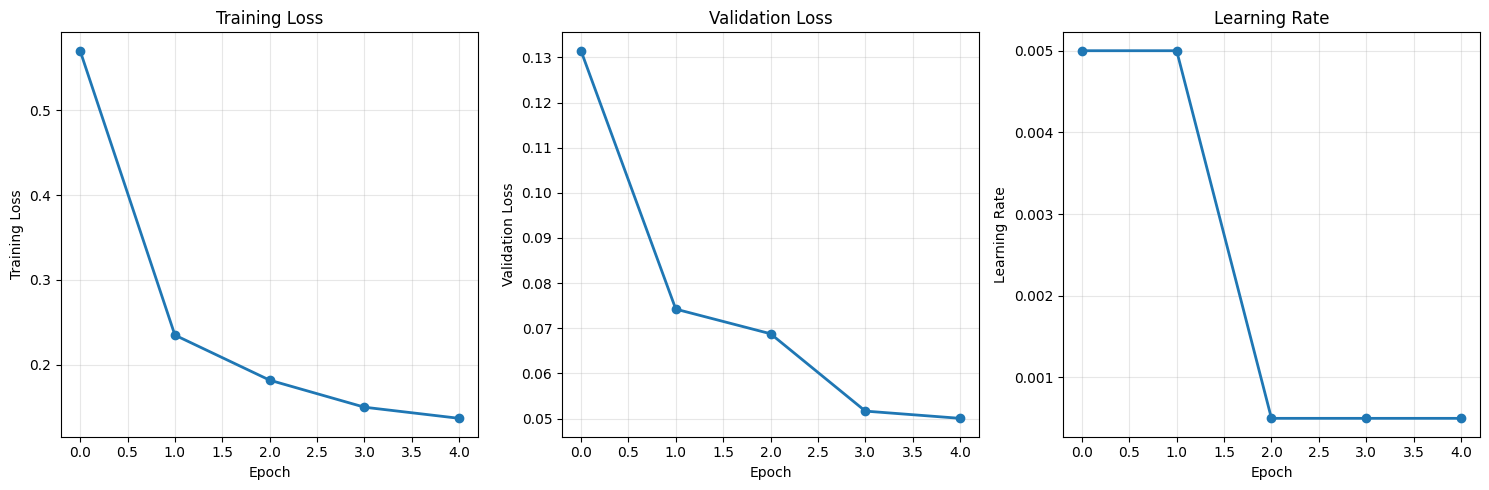

In [ ]:
plot_training_history({
    'Training Loss': history['train_loss'],
    'Validation Loss': history['val_loss'],
    'Learning Rate': history['learning_rate']
})

## 11. Final Evaluation

In [ ]:
# Prepare evaluation dataset and loader
eval_dataset = test_dataset if has_test_set else val_dataset
eval_loader = data.DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Evaluating on: {'Test' if has_test_set else 'Validation'} set")

# Load best model for this config
config_str = f"ca{int(USE_CLASS_AWARE_SAMPLING)}_mo{int(USE_MOSAIC_AUGMENTATION)}_rn{int(USE_RANDOM_AUGMENTATION)}_fl{int(USE_FOCAL_LOSS)}"
best_checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_{config_str}.pth")
best_checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.to(DEVICE)

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
if 'use_focal_loss' in best_checkpoint:
    print(f"  Focal Loss: {best_checkpoint['use_focal_loss']}")

# Evaluate
detailed_results = evaluate_map(
    model, eval_loader, DEVICE,
    iou_threshold=0.5,
    confidence_threshold=0.05
)

print("\nDetailed Results at IoU=0.5:")
print_metrics(detailed_results, class_names=eval_dataset.categories)

Evaluating on: Test set
Loaded best model from epoch 5
  Focal Loss: False

Detailed Results at IoU=0.5:

Evaluation Metrics
mAP@0.5: 0.8054
--------------------------------------------------
  1: 0.7346
  2: 0.9500
  3: 0.6400
  4: 0.7799
  5: 0.9621
  6: 0.7658

